我的逻辑是
首先初始化一个全为0的pred_mask, 按照类别id的顺序遍历每一个yolo预测的bbox，
然后每一个框送进sam得到分割结果，按照相应的类别id填到pred_mask上，
遍历完所有的bbox得到最终的预测分割图之后，再和ground_truth_mask算每一个类别的iou,以及可视化原rgb图片，预测的分割图，真实的分割图

shell IOU : 0.9817      fin IOU : 0.9599      head IOU : 0.8068      


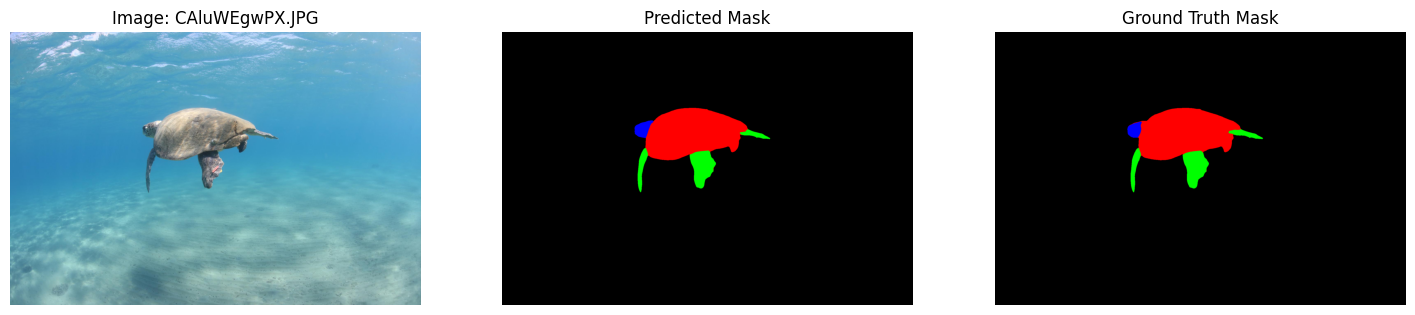

shell IOU : 0.9821      fin IOU : 0.9822      head IOU : 0.7975      


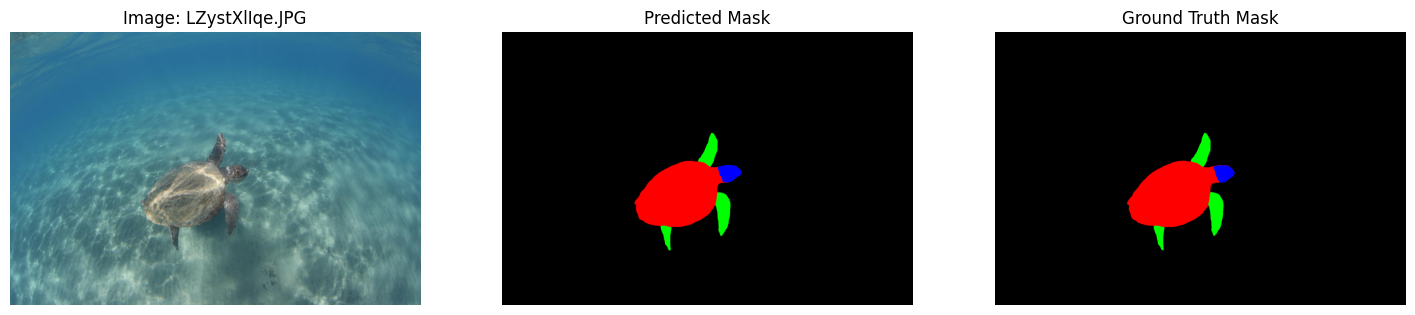

shell IOU : 0.9737      fin IOU : 0.9752      head IOU : 0.8982      


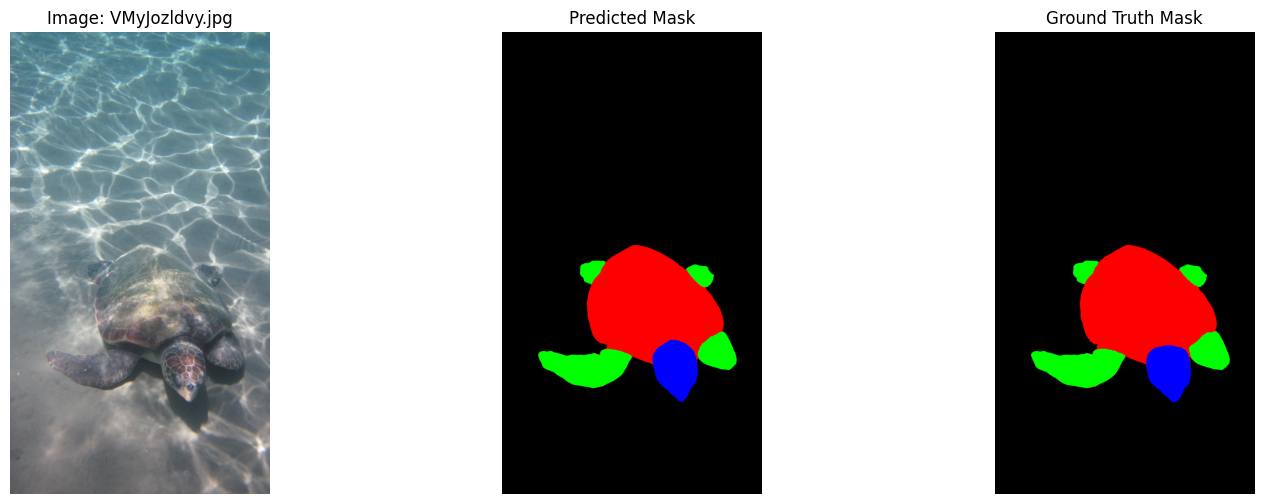

shell IOU : 0.8427      fin IOU : 0.7533      head IOU : 0.6070      


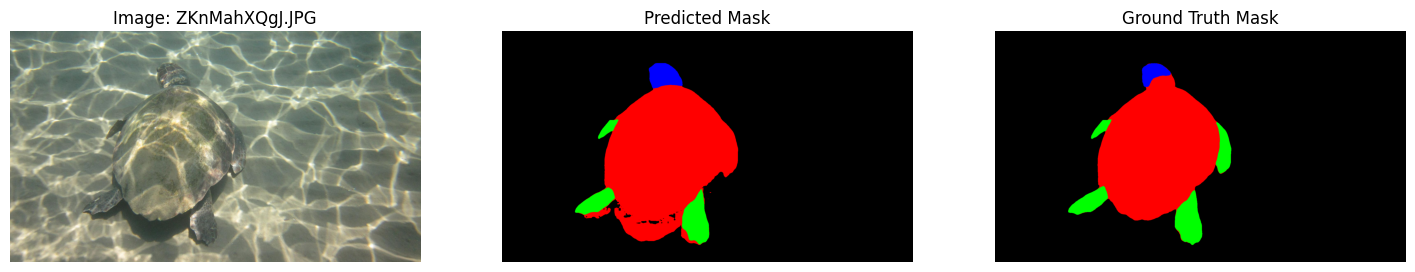

shell IOU : 0.9595      fin IOU : 0.9849      head IOU : 0.7428      


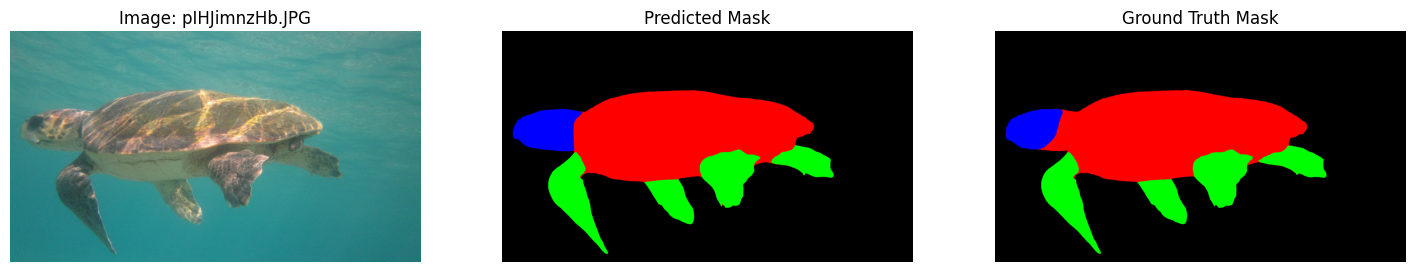

shell IOU : 0.9915      fin IOU : 0.9795      head IOU : 0.9364      


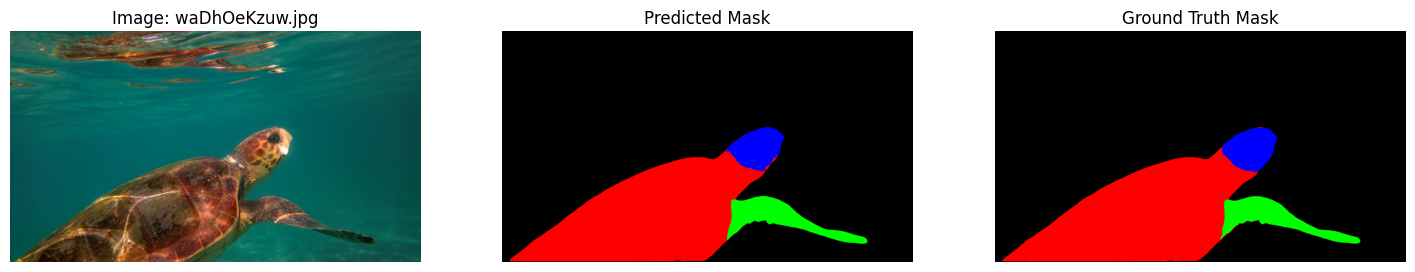

shell IOU : 0.9944      fin IOU : 0.7631      head IOU : 0.6615      


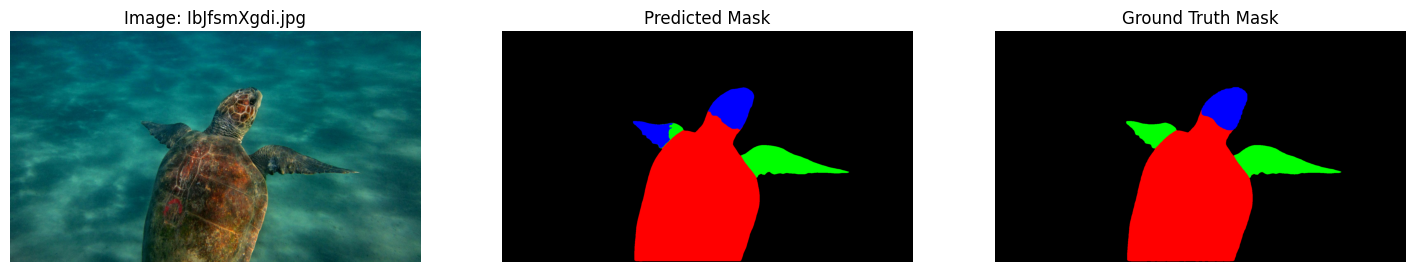

shell IOU : 0.9825      fin IOU : 0.9869      head IOU : 0.9381      


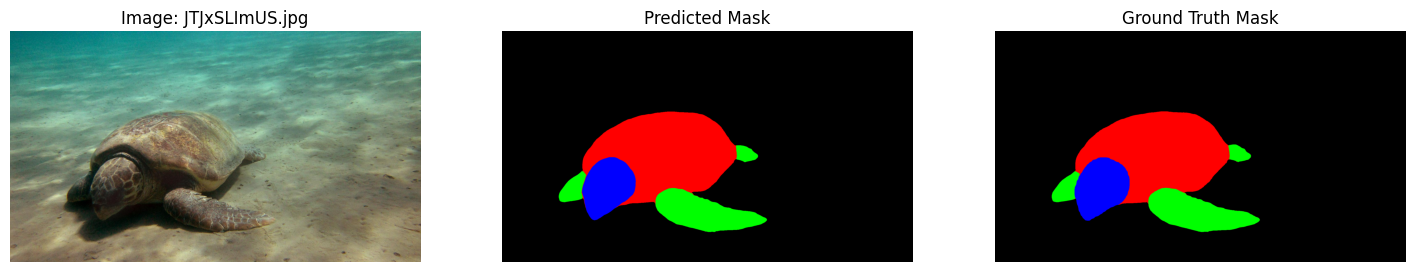

shell IOU : 0.9750      fin IOU : 0.9931      head IOU : 0.7051      


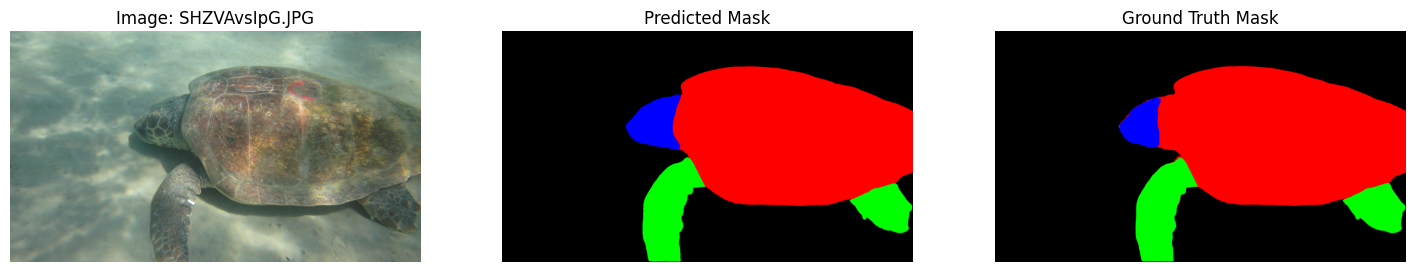

shell IOU : 0.9733      fin IOU : 0.9735      head IOU : 0.7891      


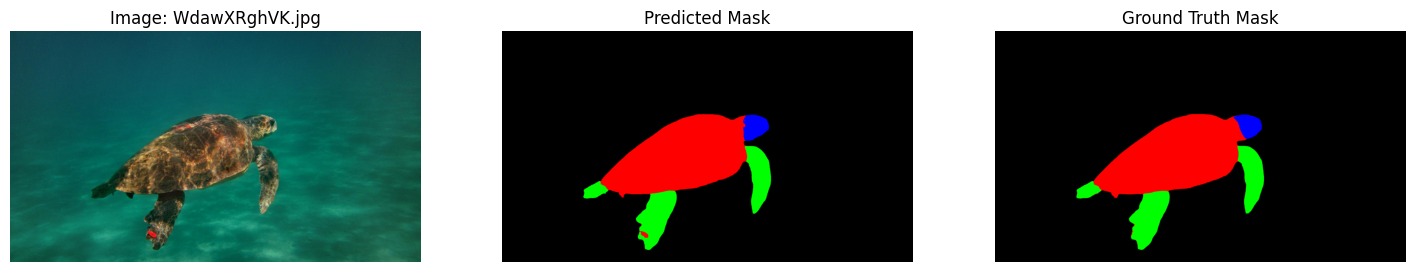

shell IOU : 0.9324      fin IOU : 0.6898      head IOU : 0.9023      


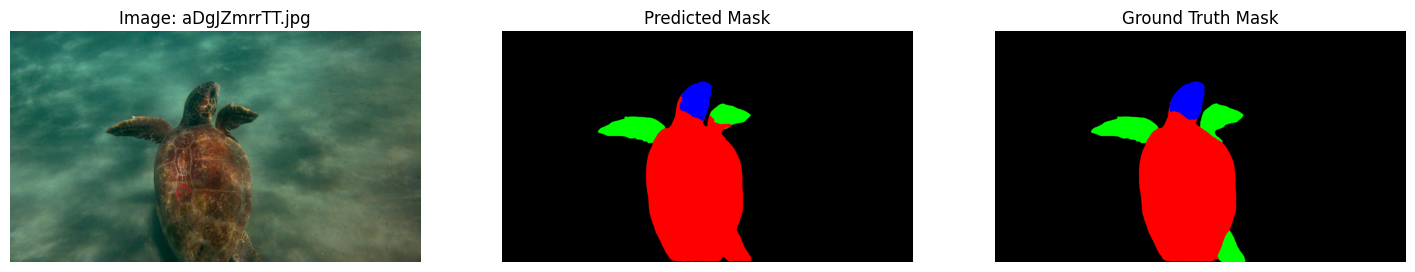

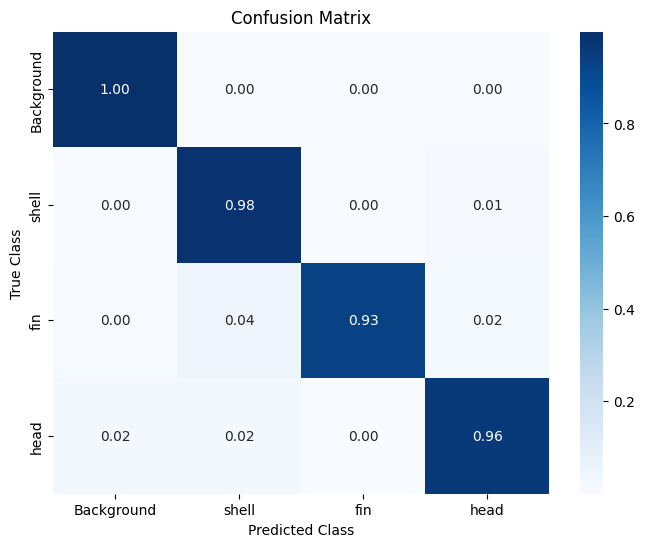

Average IOU for shell: 0.9626
Average IOU for fin: 0.9129
Average IOU for head: 0.7986


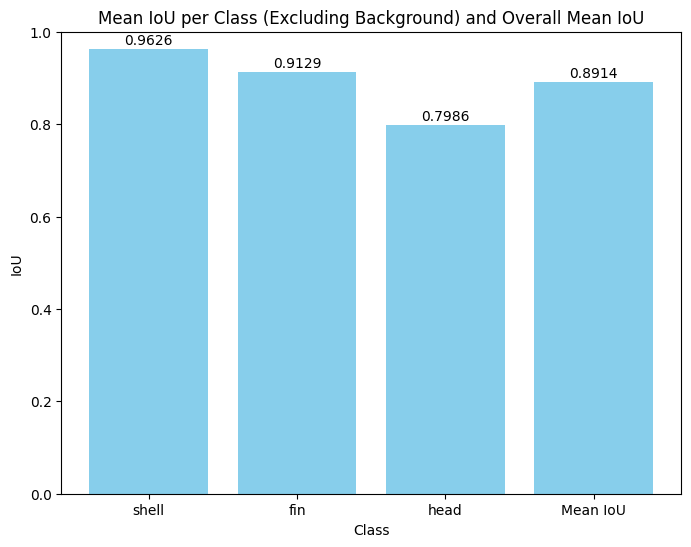

In [18]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from sklearn.metrics import jaccard_score, confusion_matrix
from pycocotools import mask as coco_mask
from ultralytics import YOLO
from collections import defaultdict
import torch
import seaborn as sns
import os

# Configure paths
annotations_path = '/root/autodl-fs/archive/turtles-data/data/annotations_test.json'
image_folder = '/root/autodl-fs/archive/turtles-data/data/'
sam_checkpoint = "/root/autodl-fs/sam_vit_h_4b8939.pth"
yolo_checkpoint = "/root/autodl-fs/best.pt"

# Load JSON file to get all images and annotations information
with open(annotations_path, 'r') as f:
    data = json.load(f)

# Load YOLOv8 and SAM models on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(yolo_checkpoint).to(device)
yolo_model.overrides['verbose'] = False  # 禁用 YOLO 推理详细输出
torch.use_deterministic_algorithms(False)  # 避免非确定性警告
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

# Initialize IoU accumulations and counts for each category
iou_scores = defaultdict(float)  # Accumulated IoU per category
iou_counts = defaultdict(int)     # Count of masks per category
category_names = ['shell', 'fin', 'head']
conf_matrix_total = np.zeros((len(category_names) + 1, len(category_names) + 1), dtype=int)  # Including background

# Colors for visualization
category_colors = {
    0: [1, 0, 0],     # Red
    1: [0, 1, 0],     # Green
    2: [0, 0, 1],     # Blue
}

def visualize(image_np, pred_colored_mask, gt_colored_mask, image_name, output_dir="visualizations"):
    save_dir = os.path.join(output_dir)
    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.basename(image_name)
    output_path = os.path.join(save_dir, f"{os.path.splitext(base_name)[0]}_visualization.png")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image_np)
    axes[0].set_title(f"Image: {base_name}")
    axes[0].axis("off")
    
    axes[1].imshow(pred_colored_mask)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    axes[2].imshow(gt_colored_mask)
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis("off")
    
    plt.show()
    # plt.savefig(output_path)
    plt.close(fig)
    # print(f"Visualization saved to {output_path}")

# Loop through all images in the dataset
for idx, image_info in enumerate(data['images']):
    image_id = image_info['id']
    annotations_info = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    
    # Load image
    image_path = f"{image_folder}/{image_info['file_name']}"
    image = Image.open(image_path)
    image_np = np.array(image)

    # Initialize blank masks for predictions and ground truth
    pred_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=int)
    gt_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=int)

    # Get YOLOv8 predicted bounding boxes
    results = yolo_model.predict(source=image_path, imgsz=256, device=device)
    bboxes = results[0].boxes.xyxy.cpu().numpy()  # YOLOv8 bounding boxes
    class_ids = results[0].boxes.cls.cpu().numpy()  # YOLOv8 class IDs

    # Set SAM model image
    predictor.set_image(image_np)
    
    # Sort bboxes and class_ids by class_id
    sorted_bboxes = sorted(zip(bboxes, class_ids), key=lambda x: x[1])

    # Process each bbox in sorted order
    for bbox, class_id in sorted_bboxes:
        x_min, y_min, x_max, y_max = bbox
        box_prompt = np.array([x_min, y_min, x_max, y_max]).reshape(1, -1)

        # Predict segmentation mask with SAM and select the highest-confidence mask
        masks, scores, _ = predictor.predict(box=box_prompt)
        best_mask = masks[np.argmax(scores)]  # Select the mask with the highest score

        # Assign the class ID to the pred_mask at the locations where the mask is true
        category_id = int(class_id) + 1  # Convert to category_id starting from 1
        pred_mask[best_mask > 0] = category_id

    # Prepare ground truth mask
    sorted_annotations = sorted(annotations_info, key=lambda ann: ann['category_id'])
    for ann in sorted_annotations:
        category_id = ann['category_id']
        rle_encoded = ann['segmentation']
        gt_mask_category = coco_mask.decode(coco_mask.frPyObjects(rle_encoded, image_np.shape[0], image_np.shape[1])).astype(bool)
        gt_mask[gt_mask_category] = category_id  # Assign the category ID to gt_mask

    # Flatten masks for confusion matrix calculation
    pred_mask_flat = pred_mask.flatten()
    gt_mask_flat = gt_mask.flatten()
    conf_matrix_image = confusion_matrix(gt_mask_flat, pred_mask_flat, labels=range(len(category_names) + 1))
    conf_matrix_total += conf_matrix_image  # Accumulate confusion matrix across all images

    # Calculate IoU for each category
    pred_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))
    gt_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))
    
    for class_id, class_name in enumerate(category_names, start=1):
        pred_class_mask = (pred_mask == class_id).astype(int).flatten()
        gt_class_mask = (gt_mask == class_id).astype(int).flatten()
        
        # Calculate IoU
        if np.any(gt_class_mask) or np.any(pred_class_mask):  # Only calculate if there are relevant pixels
            iou = jaccard_score(gt_class_mask, pred_class_mask, average='binary')
            iou_scores[class_name] += iou
            iou_counts[class_name] += 1
            print(f"{class_name} IOU : {iou:.4f}",end = '      ')
        
        # Colorize masks for visualization
        color = category_colors.get(class_id - 1, [1, 1, 1])
        pred_colored_mask[pred_mask == class_id] = color
        gt_colored_mask[gt_mask == class_id] = color
    print()
    # Visualize every 10 images
    visualize(image_np, pred_colored_mask, gt_colored_mask, image_info['file_name'])
    if idx == 10:
        break

# 将混淆矩阵归一化
conf_matrix_normalized = conf_matrix_total.astype('float') / conf_matrix_total.sum(axis=1, keepdims=True)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Background'] + category_names,
            yticklabels=['Background'] + category_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()
plt.close()

# Calculate and print the average IoU for each category
mean_ious = []
for class_name in category_names:
    if iou_counts[class_name] > 0:
        avg_iou = iou_scores[class_name] / iou_counts[class_name]
        mean_ious.append(avg_iou)
        print(f"Average IOU for {class_name}: {avg_iou:.4f}")
    else:
        mean_ious.append(0)
        print(f"No predictions for {class_name}")

# Plot Mean IoU per Class
plt.figure(figsize=(8, 6))
bars = plt.bar(category_names + ["Mean IoU"], mean_ious + [np.mean(mean_ious)], color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center')
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("IoU")
plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
plt.show()
plt.close()
